In [ ]:
#  Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, cohen_kappa_score,
                             matthews_corrcoef, classification_report)
from transformers import PerceiverModel, PerceiverConfig
import json
import time
import pprint
from transformers import ViTForImageClassification, ViTConfig



In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

DATA_DIR = '/content/gdrive/MyDrive/AI_Project_daraset'

Mounted at /content/gdrive


In [ ]:
import zipfile

output_dir = '/content/eeg_unzipped'
os.makedirs(output_dir, exist_ok=True)

zip_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.zip')])
print(f"Found {len(zip_files)} zip files.")

valid_subjects = []

for i, zip_file in enumerate(zip_files, 1):
    subject_id = int(os.path.splitext(zip_file)[0])
    subject_dir = os.path.join(output_dir, str(subject_id))
    os.makedirs(subject_dir, exist_ok=True)
    try:
        with zipfile.ZipFile(os.path.join(DATA_DIR, zip_file), 'r') as zip_ref:
            print(f"{i} — Unzipping {zip_file}...")
            zip_ref.extractall(subject_dir)
            valid_subjects.append(subject_id)
    except zipfile.BadZipFile:
        print(f"Skipping {zip_file} — not a valid zip file.")
    except Exception as e:
        print(f"Error unzipping {zip_file}: {e}")

valid_subjects = sorted(valid_subjects)
print(f" Total valid subjects: {len(valid_subjects)} — IDs: {valid_subjects}")

Found 109 zip files.
1 — Unzipping 1.zip...
2 — Unzipping 10.zip...
3 — Unzipping 100.zip...
4 — Unzipping 101.zip...
5 — Unzipping 102.zip...
6 — Unzipping 103.zip...
7 — Unzipping 104.zip...
Skipping 105.zip — not a valid zip file.
Skipping 106.zip — not a valid zip file.
Skipping 107.zip — not a valid zip file.
Skipping 108.zip — not a valid zip file.
Skipping 109.zip — not a valid zip file.
13 — Unzipping 11.zip...
14 — Unzipping 12.zip...
15 — Unzipping 13.zip...
16 — Unzipping 14.zip...
17 — Unzipping 15.zip...
18 — Unzipping 16.zip...
19 — Unzipping 17.zip...
20 — Unzipping 18.zip...
21 — Unzipping 19.zip...
22 — Unzipping 2.zip...
23 — Unzipping 20.zip...
24 — Unzipping 21.zip...
25 — Unzipping 22.zip...
26 — Unzipping 23.zip...
27 — Unzipping 24.zip...
28 — Unzipping 25.zip...
29 — Unzipping 26.zip...
30 — Unzipping 27.zip...
31 — Unzipping 28.zip...
32 — Unzipping 29.zip...
33 — Unzipping 3.zip...
34 — Unzipping 30.zip...
35 — Unzipping 31.zip...
36 — Unzipping 32.zip...
37 —

In [ ]:
# Path to the unzipped folder in Google Drive
base_dir = '/content/eeg_unzipped'

# Lists to hold data and subject IDs
valid_subjects = []
valid_subjects_data = []

import psutil

# Get virtual memory info
vm = psutil.virtual_memory()

# Print summary
print(f"Total RAM: {vm.total / 1e9:.2f} GB")
print(f"Available RAM: {vm.available / 1e9:.2f} GB")
print(f"Used RAM: {(vm.total - vm.available) / 1e9:.2f} GB")
print(f"Percentage Used: {vm.percent}%")


# Walk through each subject folder
for subject_folder in sorted(os.listdir(base_dir)):
    subject_path = os.path.join(base_dir, subject_folder)

    if os.path.isdir(subject_path):
        npy_files = [f for f in os.listdir(subject_path) if f.endswith('.npy')]

        if npy_files:
            for npy_file in npy_files:
                npy_path = os.path.join(subject_path, npy_file)

                try:
                    data = np.load(npy_path)
                    valid_subjects.append(subject_folder)
                    valid_subjects_data.append(data)
                    print(f" Loaded {npy_file} from subject {subject_folder}, shape: {data.shape}")
                    print(f"Total RAM: {vm.total / 1e9:.2f} GB")
                    print(f"Available RAM: {vm.available / 1e9:.2f} GB")
                    print(f"Used RAM: {(vm.total - vm.available) / 1e9:.2f} GB")
                    print(f"Percentage Used: {vm.percent}%")
                except Exception as e:
                    print(f"Failed to load {npy_file} from subject {subject_folder}: {e}")
        else:
            print(f"⚠️ No .npy files found in {subject_folder}")

print(f"\n Total valid subjects loaded: {len(valid_subjects)}")

In [ ]:

with_gpu = torch.cuda.is_available()
device = torch.device("cuda" if with_gpu else "cpu")
print(f'We are using {device} now.')


We are using cuda now.


In [ ]:
# 📂 Parameters
DATA_DIR = '/content/eeg_unzipped'

TRAIN_IDS = list(range(1, 74))
DEV_IDS = list(range(75, 89))
TEST_IDS = list(range(90, 104))
no_feature = 64
segment_length = 64
n_class = 4
removed_labels = [0,1,4,5,6,7,8,9,10]


# ⚙️ Segmentation function
# Segmentation function
# Segmentation function
def extract(input, n_classes, n_fea, time_window, moving):
    xx, yy = input[:, :n_fea], input[:, n_fea:n_fea + 1]
    new_x, new_y = [], []
    for i in range(int((xx.shape[0] / moving) - 1)):
        ave_y = np.average(yy[int(i * moving):int(i * moving + time_window)])
        new_x.append(xx[int(i * moving):int(i * moving + time_window), :])
        window = yy[int(i * moving):int(i * moving + time_window)]
        label = np.bincount(window.astype(int).flatten()).argmax()
        new_y.append(label)

    new_x = np.array(new_x).reshape([-1, n_fea * time_window])
    new_y = np.array(new_y).reshape([-1, 1])

    return np.vstack((np.hstack((new_x, new_y)), np.hstack((new_x[-1], new_y[-1]))))




In [ ]:
def load_subjects(ids):
    X_list, y_list = [], []
    for sid in ids:
        path = os.path.join(DATA_DIR, f'{sid}', f'{sid}.npy')
        if not os.path.exists(path):
            print(f"⚠️ Skipping missing {sid}")
            continue
        data = np.load(path)
        print(f'shape = {data.shape}')

        # Segment the data
        seg_data = extract(data, n_class, no_feature, segment_length, segment_length / 2)
        X_list.append(seg_data[:, :-1])
        y_list.append(seg_data[:, -1])

    # Combine all data
    X = np.vstack(X_list)
    y = np.hstack(y_list)

    # Keep only desired labels intended to classify against
    mask = (y == 2) | (y == 3) | (y == 6) | (y == 7)
    X, y = X[mask], y[mask]

    # Map to class indices: 2 → 0, 3 → 1, 6 → 2, 7 → 3
    label_map = {2: 0, 3: 1, 6: 2, 7: 3}
    y = np.vectorize(label_map.get)(y)

    return X, y




print("Loading data...")
X_train_raw, y_train = load_subjects(TRAIN_IDS)
X_dev_raw, y_dev = load_subjects(DEV_IDS)
X_test_raw, y_test = load_subjects(TEST_IDS)

print(f" Train: {X_train_raw.shape}, Dev: {X_dev_raw.shape}, Test: {X_test_raw.shape}")


⏳ Loading data...
shape = (259520, 65)
shape = (255680, 65)
shape = (259520, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (259520, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255520, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (259520, 65)
shape = (259520, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (257600, 65)
shape = (257600, 65)
shape = (255680, 65)
shape = (259520, 65)
shape = (255680, 65)
shape = (255840, 65)
shape = (259520, 65)
shape = (255680, 65)
shape = (255840, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (256320, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (255680, 65)
shape = (259520, 65)
shape = (255680,

In [ ]:
# Normalize
scaler = StandardScaler().fit(X_train_raw.reshape(-1, no_feature))
X_train = scaler.transform(X_train_raw.reshape(-1, no_feature)).reshape(-1, segment_length, no_feature)
X_dev = scaler.transform(X_dev_raw.reshape(-1, no_feature)).reshape(-1, segment_length, no_feature)
X_test = scaler.transform(X_test_raw.reshape(-1, no_feature)).reshape(-1, segment_length, no_feature)

# Convert to torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32).to(device)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        # if bidirectional set to true:
        self.fc = nn.Linear(hidden_size * 2, num_classes)

        #self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
batch_size = 32
epochs = 30
hidden_size = 128
lr = 0.001

experiment_list = [
    {'trial': 1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'hidden_size': 128, 'num_layers': 1},
    {'trial': 2, 'learning_rate': 1e-3, 'batch_size': 32, 'epochs': 50, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3},
    {'trial': 3, 'learning_rate': 5e-4, 'batch_size': 64, 'epochs': 50, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3},
    {'trial': 4, 'learning_rate': 1e-4, 'batch_size': 32, 'epochs': 100, 'hidden_size': 256, 'num_layers': 3, 'dropout': 0.4},
    {'trial': 5, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 60, 'hidden_size': 256, 'num_layers': 3, 'dropout': 0.5},
]

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
dev_ds = TensorDataset(X_dev_tensor, y_dev_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

#uncomment to test LSTM alone
# model = LSTMClassifier(input_size=no_feature, hidden_size=hidden_size, num_classes=n_class).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()



In [ ]:
def evaluate(loader, model, device):
    model.eval()
    preds, labels, probs = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            soft_out = F.softmax(out, dim=1).cpu().numpy()
            preds.extend(np.argmax(soft_out, axis=1))
            probs.extend(soft_out)
            labels.extend(yb.cpu().numpy())

    acc = accuracy_score(labels, preds)
    prec_weighted = precision_score(labels, preds, average='weighted')
    rec_weighted = recall_score(labels, preds, average='weighted')
    f1_weighted = f1_score(labels, preds, average='weighted')
    prec_macro = precision_score(labels, preds, average='macro')
    rec_macro = recall_score(labels, preds, average='macro')
    f1_macro = f1_score(labels, preds, average='macro')
    mcc = matthews_corrcoef(labels, preds)
    kappa = cohen_kappa_score(labels, preds)
    conf_matrix = confusion_matrix(labels, preds).tolist()

    encoder = OneHotEncoder(sparse_output=False)
    y_true_onehot = encoder.fit_transform(np.array(labels).reshape(-1,1))
    auc = roc_auc_score(y_true_onehot, np.array(probs))
    report = classification_report(labels, preds, digits=4)

    return {
        'accuracy': acc, 'precision_weighted': prec_weighted, 'recall_weighted': rec_weighted, 'f1_weighted': f1_weighted,
        'precision_macro': prec_macro, 'recall_macro': rec_macro, 'f1_macro': f1_macro,
        'matthews_corrcoef': mcc, 'cohen_kappa': kappa, 'auc': auc,
        'confusion_matrix': conf_matrix, 'classification_report': report
    }



In [ ]:
    # Evaluate with time tracking
    def timed_evaluate(loader, model, device):
        start_eval = time.perf_counter()
        metrics = evaluate(loader, model, device)
        end_eval = time.perf_counter()
        metrics['time_seconds'] = end_eval - start_eval
        print(f"Evaluation time: {metrics['time_seconds']:.2f} seconds")
        return metrics

EEGNet

In [ ]:
pip install braindecode


In [ ]:

#  Reshape to match EEGNet input
scaler = StandardScaler().fit(X_train_raw.reshape(-1, no_feature))
X_train = scaler.transform(X_train_raw.reshape(-1, no_feature)).reshape(-1, segment_length, no_feature)
X_dev = scaler.transform(X_dev_raw.reshape(-1, no_feature)).reshape(-1, segment_length, no_feature)
X_test = scaler.transform(X_test_raw.reshape(-1, no_feature)).reshape(-1, segment_length, no_feature)
print(X_train)
X_train = X_train.transpose(0, 2, 1).astype(np.float32)
X_dev = X_dev.transpose(0, 2, 1).astype(np.float32)
X_test = X_test.transpose(0, 2, 1).astype(np.float32)

[[[-2.97979996e-01  1.10431059e-01  1.44580998e-01 ...  2.30435790e-01
   -1.68691313e-03 -1.40127650e-01]
  [-1.67037696e-01  6.38607348e-03  2.33512302e-01 ...  1.18483598e-01
   -1.96797623e-01 -2.98740245e-01]
  [-2.15462520e-02  1.10431059e-01  1.89046650e-01 ...  1.82456279e-01
   -2.61834526e-01 -3.18566819e-01]
  ...
  [-8.94494917e-01 -1.04892735e+00 -9.07772762e-01 ... -9.69051981e-01
   -1.31868421e+00 -9.53017200e-01]
  [-1.11273208e+00 -1.03406378e+00 -8.18841458e-01 ... -1.03302466e+00
   -1.17235117e+00 -9.72843774e-01]
  [-7.78101761e-01 -5.88156699e-01 -3.89006824e-01 ... -5.53229553e-01
   -5.87019043e-01 -3.58219968e-01]]

 [[-2.83430851e-01 -8.27953423e-02 -1.84597252e-02 ...  1.98449450e-01
   -1.48019946e-01 -1.20301075e-01]
  [-3.41627429e-01 -1.27386050e-01 -1.37034797e-01 ...  8.64972577e-02
   -2.78093752e-01  1.84849455e-02]
  [-4.14373151e-01 -3.94930298e-01 -5.07581895e-01 ... -2.65352488e-01
   -4.73204462e-01 -4.09947777e-02]
  ...
  [ 5.31321236e-01  7.7

In [ ]:

from braindecode.models import EEGNetv4
from braindecode.util import set_random_seeds

# Load data and ensure correct shape
# X shape must be (samples, channels, time)
X_train = X_train.transpose(0, 2, 1).astype(np.float32)
X_dev = X_dev.transpose(0, 2, 1).astype(np.float32)
X_test = X_test.transpose(0, 2, 1).astype(np.float32)

y_train = y_train.astype(np.int64)
y_dev = y_dev.astype(np.int64)
y_test = y_test.astype(np.int64)

#  Dataloaders
batch_size = 64
train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(TensorDataset(torch.tensor(X_dev), torch.tensor(y_dev)), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=batch_size)

#  EEGNet Model
set_random_seeds(seed=2023, cuda=torch.cuda.is_available())

n_channels = X_train.shape[1]
input_time_length = X_train.shape[2]
n_classes = len(np.unique(y_train))



n_channels = 64  # From your data
sfreq = 160      # Sampling frequency (Hz)
duration = X_train.shape[2] / sfreq  # Window duration in seconds


model = EEGNetv4(
    n_chans=64,
    n_outputs=4,
    input_window_samples=X_train.shape[2],  # Time steps
    pool_mode='mean',
    drop_prob=0.5,  # Increased dropout
    final_conv_length='auto'
).cuda()

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight, gain=0.1)
model.apply(weights_init)
# ⚙️ Training setup
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 🏋️ Training loop
n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    train_loss, correct = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        correct += (out.argmax(dim=1) == yb).sum().item()
    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{n_epochs} — Loss: {train_loss:.2f} — Accuracy: {acc:.4f}")

def evaluate(loader, split=""):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.cuda()
            out = model(xb)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())
    print(f"\n📊 {split} metrics")
    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("Precision:", precision_score(all_labels, all_preds, average='weighted', zero_division=0))
    print("Recall:", recall_score(all_labels, all_preds, average='weighted', zero_division=0))
    print("F1:", f1_score(all_labels, all_preds, average='weighted', zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(all_labels, all_preds))
    print("Classification report:\n", classification_report(all_labels, all_preds))

evaluate(train_loader, "Train")
evaluate(dev_loader, "Dev")
evaluate(test_loader, "Test")


/usr/local/lib/python3.11/dist-packages/braindecode/models/eegnet.py:129: RuntimeWarning: The parameter `third_kernel_size` is deprecated and will be removed in a future version.
  warn(


Epoch 1/30 — Loss: 191032.69 — Accuracy: 0.2757
Epoch 2/30 — Loss: 188742.49 — Accuracy: 0.3004
Epoch 3/30 — Loss: 186814.02 — Accuracy: 0.3229
Epoch 4/30 — Loss: 185586.05 — Accuracy: 0.3350
Epoch 5/30 — Loss: 184771.48 — Accuracy: 0.3417
Epoch 6/30 — Loss: 184273.64 — Accuracy: 0.3474
Epoch 7/30 — Loss: 183783.26 — Accuracy: 0.3518
Epoch 8/30 — Loss: 183003.05 — Accuracy: 0.3598
Epoch 9/30 — Loss: 182229.27 — Accuracy: 0.3656
Epoch 10/30 — Loss: 181875.99 — Accuracy: 0.3683
Epoch 11/30 — Loss: 181518.89 — Accuracy: 0.3705
Epoch 12/30 — Loss: 181167.04 — Accuracy: 0.3711
Epoch 13/30 — Loss: 181121.50 — Accuracy: 0.3725
Epoch 14/30 — Loss: 180830.12 — Accuracy: 0.3756
Epoch 15/30 — Loss: 180583.30 — Accuracy: 0.3760
Epoch 16/30 — Loss: 180506.24 — Accuracy: 0.3777
Epoch 17/30 — Loss: 180357.87 — Accuracy: 0.3771
Epoch 18/30 — Loss: 180120.76 — Accuracy: 0.3789
Epoch 19/30 — Loss: 179825.58 — Accuracy: 0.3817
Epoch 20/30 — Loss: 179984.25 — Accuracy: 0.3813
Epoch 21/30 — Loss: 179774.36

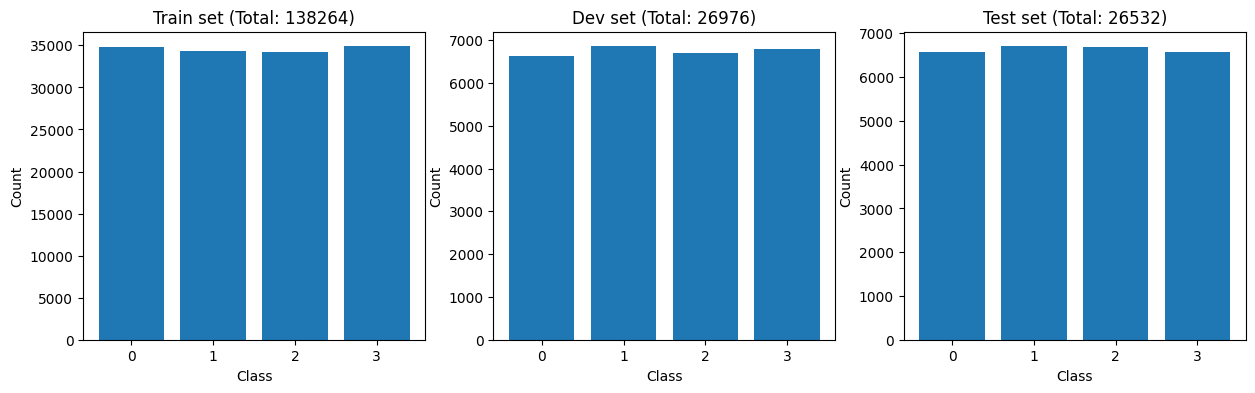

Train labels: Counter({np.int64(3): 34878, np.int64(0): 34840, np.int64(1): 34292, np.int64(2): 34254})
Dev labels: Counter({np.int64(1): 6855, np.int64(3): 6786, np.int64(2): 6702, np.int64(0): 6633})
Test labels: Counter({np.int64(1): 6701, np.int64(2): 6698, np.int64(3): 6568, np.int64(0): 6565})


In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(y_train, y_dev, y_test):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    for i, (y, name) in enumerate(zip([y_train, y_dev, y_test], ['Train', 'Dev', 'Test'])):
        unique, counts = np.unique(y, return_counts=True)
        ax[i].bar(unique, counts)
        ax[i].set_title(f'{name} set (Total: {len(y)})')
        ax[i].set_xlabel('Class')
        ax[i].set_ylabel('Count')
    plt.show()

plot_class_distribution(y_train, y_dev, y_test)
from collections import Counter
print("Train labels:", Counter(y_train))
print("Dev labels:", Counter(y_dev))
print("Test labels:", Counter(y_test))


In [ ]:
for xb, yb in train_loader:
    print("Input shape:", xb.shape)
    break


In [ ]:
import os, time, json, pprint
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from braindecode.models import EEGNetv4
from braindecode.util import set_random_seeds

def ensure_nct(x: np.ndarray, n_chans: int) -> np.ndarray:
    if x.ndim != 3:
        raise ValueError(f"Expected 3D array, got {x.shape}")
    if x.shape[1] == n_chans:
        return x.astype(np.float32, copy=False)
    if x.shape[2] == n_chans:
        return x.transpose(0, 2, 1).astype(np.float32, copy=False)
    raise ValueError(f"Cannot infer channels dim for shape {x.shape} with n_chans={n_chans}")

N_CHANS = 64
X_train = ensure_nct(X_train, N_CHANS)
X_dev   = ensure_nct(X_dev,   N_CHANS)
X_test  = ensure_nct(X_test,  N_CHANS)

y_train = y_train.astype(np.int64, copy=False)
y_dev   = y_dev.astype(np.int64,   copy=False)
y_test  = y_test.astype(np.int64,  copy=False)

n_classes = int(np.unique(y_train).size)
input_window_samples = X_train.shape[2]

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def make_loaders(batch_size: int):
    train_loader = DataLoader(
        TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
        batch_size=batch_size, shuffle=True, pin_memory=(device.type == 'cuda')
    )
    dev_loader = DataLoader(
        TensorDataset(torch.from_numpy(X_dev), torch.from_numpy(y_dev)),
        batch_size=batch_size, shuffle=False, pin_memory=(device.type == 'cuda')
    )
    test_loader = DataLoader(
        TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)),
        batch_size=batch_size, shuffle=False, pin_memory=(device.type == 'cuda')
    )
    return train_loader, dev_loader, test_loader

def make_model(drop_prob: float):
    set_random_seeds(seed=2023, cuda=(device.type == 'cuda'))
    model = EEGNetv4(
        n_chans=N_CHANS,
        n_outputs=n_classes,
        input_window_samples=input_window_samples,
        pool_mode='mean',
        drop_prob=drop_prob,
        final_conv_length='auto'
    ).to(device)
    return model

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        preds = out.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.numel()
    return total_loss / max(total, 1), correct / max(total, 1)

@torch.no_grad()
def evaluate_loader(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        out = model(xb)
        preds = out.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())
    metrics = {
        "accuracy": float(accuracy_score(all_labels, all_preds)),
        "precision_w": float(precision_score(all_labels, all_preds, average='weighted', zero_division=0)),
        "recall_w": float(recall_score(all_labels, all_preds, average='weighted', zero_division=0)),
        "f1_w": float(f1_score(all_labels, all_preds, average='weighted', zero_division=0)),
        "confusion_matrix": confusion_matrix(all_labels, all_preds).tolist(),
        "classification_report": classification_report(all_labels, all_preds, zero_division=0)
    }
    return metrics

experiment_list = [
    {"trial": 1, "learning_rate": 1e-3,  "batch_size": 64,  "epochs": 30, "dropout": 0.5},
    {"trial": 2, "learning_rate": 5e-4,  "batch_size": 32,  "epochs": 50, "dropout": 0.5},
    {"trial": 3, "learning_rate": 1e-4,  "batch_size": 64,  "epochs": 75, "dropout": 0.4},
    {"trial": 4, "learning_rate": 2e-4,  "batch_size": 128, "epochs": 50, "dropout": 0.5},
]

ALL_RESULTS = []
for exp in experiment_list:
    trial   = exp["trial"]
    lr      = exp["learning_rate"]
    bs      = exp["batch_size"]
    epochs  = exp["epochs"]
    dropout = exp.get("dropout", 0.5)

    print(f"\nRunning Trial {trial} — LR={lr}, Batch Size={bs}, Epochs={epochs}, Dropout={dropout}")

    train_loader, dev_loader, test_loader = make_loaders(bs)

    model = make_model(drop_prob=dropout)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    start_train = time.perf_counter()
    best_dev_f1 = -1.0
    best_ckpt_path = f"eegnetv4_trial{trial}.pt"

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        dev_metrics = evaluate_loader(model, dev_loader)
        print(f"Epoch {epoch:>3}/{epochs} — train_loss: {tr_loss:.4f} | train_acc: {tr_acc:.4f} | dev_f1_w: {dev_metrics['f1_w']:.4f} | dev_acc: {dev_metrics['accuracy']:.4f}")
        if dev_metrics['f1_w'] > best_dev_f1:
            best_dev_f1 = dev_metrics['f1_w']
            torch.save(model.state_dict(), best_ckpt_path)

    train_time = time.perf_counter() - start_train
    print(f"Training time: {train_time:.2f}s (trial {trial})")

    model.load_state_dict(torch.load(best_ckpt_path, map_location=device))
    train_metrics = evaluate_loader(model, train_loader)
    dev_metrics   = evaluate_loader(model, dev_loader)
    test_metrics  = evaluate_loader(model, test_loader)

    results = {
        "trial": trial,
        "learning_rate": lr,
        "batch_size": bs,
        "epochs": epochs,
        "dropout": dropout,
        "train_time_seconds": train_time,
        "train_metrics": train_metrics,
        "dev_metrics": dev_metrics,
        "test_metrics": test_metrics,
        "checkpoint_path": best_ckpt_path
    }
    ALL_RESULTS.append(results)
    pprint.pprint(results)

    with open(f"eegnetv4_across_subjects_trial{trial}.json", "w") as f:
        json.dump(results, f, indent=4)
    with open(f"eegnetv4_across_subjects_trial{trial}.txt", "w") as f:
        f.write(json.dumps(results, indent=4))

    try:
        from google.colab import files
        files.download(f"eegnetv4_across_subjects_trial{trial}.json")
        files.download(f"eegnetv4_across_subjects_trial{trial}.txt")
        files.download(best_ckpt_path)
    except Exception:
        pass

with open("eegnetv4_all_trials_summary.json", "w") as f:
    json.dump(ALL_RESULTS, f, indent=4)


new additiob

In [ ]:
# # Dataloaders
# batch_size = 64
# train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=batch_size, shuffle=True)
# dev_loader = DataLoader(TensorDataset(torch.tensor(X_dev), torch.tensor(y_dev)), batch_size=batch_size)
# test_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=batch_size)

In [ ]:


experiment_list_Perceiver = [
      # {'trial': 1, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 15,
      #   'd_latents': 256, 'd_model': 256, 'num_latents': 128, 'num_blocks': 4},

      {

      'trial': 3,
      "learning_rate": 0.0001,
      "batch_size": 32,
      "epochs": 30,
      "d_latents": 256,
      "d_model": 256,
      "num_latents": 128,
      "num_blocks": 4

      },


    {'trial': 2, 'learning_rate': 5e-4, 'batch_size': 32, 'epochs': 20,
     'd_latents': 256, 'd_model': 256, 'num_latents': 128, 'num_blocks': 5},

    {'trial': 3, 'learning_rate': 1e-4, 'batch_size': 64, 'epochs': 50,
     'd_latents': 512, 'd_model': 512, 'num_latents': 128, 'num_blocks': 4},

    {'trial': 4, 'learning_rate': 5e-4, 'batch_size': 64, 'epochs': 100,
     'd_latents': 512, 'd_model': 512, 'num_latents': 256, 'num_blocks': 6},

    {'trial': 5, 'learning_rate': 1e-3, 'batch_size': 128, 'epochs': 100,
     'd_latents': 512, 'd_model': 512, 'num_latents': 256, 'num_blocks': 8}
]


for exp in experiment_list_Perceiver:
    trial, lr, batch_size, epochs = exp['trial'], exp['learning_rate'], exp['batch_size'], exp['epochs']

    print(f"\nRunning Trial {trial} — LR={lr}, Batch Size={batch_size}, Epochs={epochs}")


    class PerceiverClassifier(nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            config = PerceiverConfig(
    input_dim=256,
    d_latents=exp['d_latents'],
    d_model=exp['d_model'],
    num_latents=exp['num_latents'],
    num_blocks=exp['num_blocks']
)
            self.input_proj = nn.Linear(no_feature, 256)
            self.perceiver = PerceiverModel(config)
            self.classifier = nn.Linear(config.d_model, num_classes)

        def forward(self, x):
            x = self.input_proj(x)
            out = self.perceiver(inputs=x).last_hidden_state
            return self.classifier(out.mean(dim=1))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PerceiverClassifier(num_classes=n_class).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Timing training
    train_start = time.perf_counter()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} — Loss: {total_loss:.4f}")
    train_end = time.perf_counter()
    train_time = train_end - train_start



    torch.save(model.state_dict(), f'lPer_across_subjects_trial{trial}.pt')
    print(f"Saved metrics and model for Trial {trial}")

    # Evaluate with time tracking
    def timed_evaluate(loader):
        start_eval = time.perf_counter()
        preds, labels, probs = [], [], []
        model.eval()
        with torch.no_grad():
            for xb, yb in loader:
                out = model(xb.to(device))
                soft_out = F.softmax(out, dim=1).cpu().numpy()
                probs.extend(soft_out)
                preds.extend(np.argmax(soft_out, axis=1))
                if yb.device.type == 'cuda':
                    labels.extend(yb.cpu().numpy())
                else:
                    labels.extend(yb.numpy())

        end_eval = time.perf_counter()
        encoder = OneHotEncoder(sparse_output=False)
        y_true_onehot = encoder.fit_transform(np.array(labels).reshape(-1, 1))
        auc = roc_auc_score(y_true_onehot, np.array(probs))
        report = classification_report(labels, preds, digits=4, output_dict=False)
        metrics = {
            'accuracy': accuracy_score(labels, preds),
            'precision_weighted': precision_score(labels, preds, average='weighted'),
            'recall_weighted': recall_score(labels, preds, average='weighted'),
            'f1_weighted': f1_score(labels, preds, average='weighted'),
            'precision_macro': precision_score(labels, preds, average='macro'),
            'recall_macro': recall_score(labels, preds, average='macro'),
            'f1_macro': f1_score(labels, preds, average='macro'),
            'matthews_corrcoef': matthews_corrcoef(labels, preds),
            'cohen_kappa': cohen_kappa_score(labels, preds),
            'auc': auc,
            'confusion_matrix': confusion_matrix(labels, preds).tolist(),
            'classification_report': report,
            'time_seconds': end_eval - start_eval
        }
        return metrics


    print("Evaluating on train set...")
    train_metrics = timed_evaluate(train_loader)
    print("Evaluating on Dev set...")
    dev_metrics = timed_evaluate(dev_loader)
    print("Evaluating on Test set...")
    test_metrics = timed_evaluate(test_loader)

    all_results = {
        'trial': trial,
        'learning_rate': lr,
        'batch_size': batch_size,
        'epochs': epochs,
        'train_time_seconds': train_time,
        'train_metrics': train_metrics,
        'dev_metrics': dev_metrics,
        'test_metrics': test_metrics
    }

    print(json.dumps(all_results, indent=4))


    # Save metrics
    with open(f'perceiver_across_subjects_trial{trial}.json', 'w') as f:
        json.dump(all_results, f, indent=4)
    with open(f'perceiver_across_subjects_trial{trial}.txt', 'w') as f:
        f.write(json.dumps(all_results, indent=4))


    # Save model
    torch.save(model.state_dict(), f'perceiver_across_subjects_trial{trial}.pt')
    print(f" Saved metrics and model for Trial {trial}")
    files.download(f'perceiver_across_subjects_trial{trial}.json')
    files.download(f'perceiver_across_subjects_trial{trial}.txt')


🔸 Running Trial 3 — LR=0.0001, Batch Size=32, Epochs=30
Epoch 1/30 — Loss: 6104.0329
Epoch 2/30 — Loss: 5924.1421
Epoch 3/30 — Loss: 5912.3782
Epoch 4/30 — Loss: 5791.8336
Epoch 5/30 — Loss: 5714.1789
Epoch 6/30 — Loss: 5633.3907
Epoch 7/30 — Loss: 5568.4023
Epoch 8/30 — Loss: 5483.9981
Epoch 9/30 — Loss: 5441.8832
Epoch 10/30 — Loss: 5361.1386
Epoch 11/30 — Loss: 5256.1566
Epoch 12/30 — Loss: 5136.0357
Epoch 13/30 — Loss: 5006.2822
Epoch 14/30 — Loss: 4856.9524
Epoch 15/30 — Loss: 4688.4227
Epoch 16/30 — Loss: 4493.6697
Epoch 17/30 — Loss: 4271.6848
Epoch 18/30 — Loss: 4031.4726
Epoch 19/30 — Loss: 3754.0275
Epoch 20/30 — Loss: 3453.7116
Epoch 21/30 — Loss: 3149.8573
Epoch 22/30 — Loss: 2862.7199
Epoch 23/30 — Loss: 2579.9359
Epoch 24/30 — Loss: 2324.4226
Epoch 25/30 — Loss: 2116.7035
Epoch 26/30 — Loss: 1903.4852
Epoch 27/30 — Loss: 1715.3092
Epoch 28/30 — Loss: 1566.2442
Epoch 29/30 — Loss: 1432.6194
Epoch 30/30 — Loss: 1305.6715
Saved metrics and model for Trial 3
🔹 Evaluating on 

NameError: name 'files' is not defined

# New Section